**缺失值分析**  
每个维度缺失值情况不一样 就task01 介绍异常值情况  
rentType '--' ，'未知方式'  
buildYear '暂无信息'  
houseToward '暂无信息'  
... 

# 缺失值处理

In [24]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

In [25]:
#载入数据
data_train = pd.read_csv('./数据集/train_data.csv')
data_train['Type'] = 'Train'
data_test = pd.read_csv('./数据集/test_a.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data_train, data_test], ignore_index=True)

将rentType的"--"转换成"未知方式"类别；  
pv/pu的缺失值用均值填充；  
buildYear存在"暂无信息"，将其用众数填充。  

In [26]:
data_train['rentType'][data_train['rentType'] == '--'] = '未知方式'
data_train['rentType'].value_counts()

未知方式    30764
整租       5472
合租       5204
Name: rentType, dtype: int64

count      79.000000
mean      524.556962
std       825.030438
min         1.000000
25%        10.500000
50%       153.000000
75%       831.000000
max      5659.000000
Name: buildYear, dtype: float64


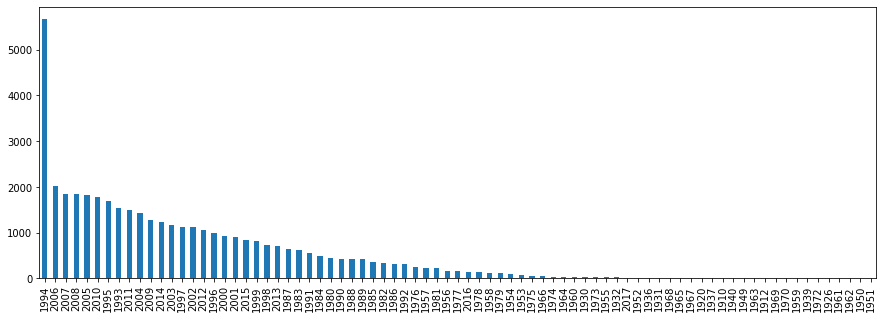

In [27]:
# 将buildYear列转换为整型数据
buildYearmean = pd.DataFrame(data_train[data_train['buildYear'] != '暂无信息']['buildYear'].mode())
data_train.loc[data_train[data_train['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmean.iloc[0, 0]
data_train['buildYear'] = data_train['buildYear'].astype('int')
print(data_train['buildYear'].value_counts().describe())
plt.figure(figsize=(15,5))
data_train['buildYear'].value_counts().plot.bar()

count     41440.000000
mean      26945.663224
std       32167.649262
min          17.000000
25%        7970.750000
50%       20196.000000
75%       34485.000000
max      621864.000000
Name: pv, dtype: float64
count    41440.000000
mean      3089.077051
std       2954.064724
min          6.000000
25%       1053.000000
50%       2391.000000
75%       4233.000000
max      39876.000000
Name: uv, dtype: float64


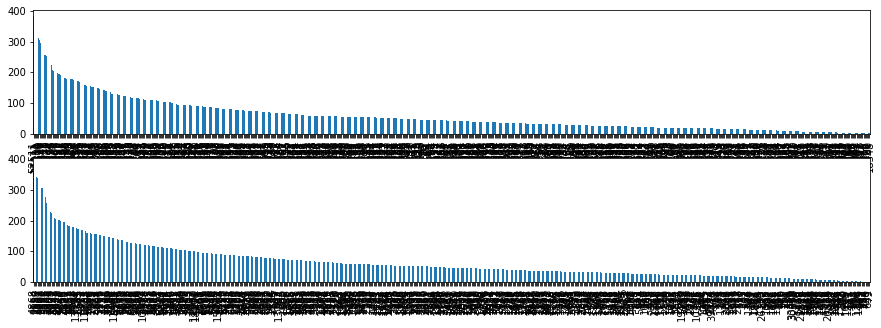

In [28]:
# 处理pv和uv的空值
data_train['pv'].fillna(data_train['pv'].mean(), inplace=True)
data_train['uv'].fillna(data_train['uv'].mean(), inplace=True)
data_train['pv'] = data_train['pv'].astype('int')
data_train['uv'] = data_train['uv'].astype('int')
print(data_train['pv'].describe())
print(data_train['uv'].describe())
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
data_train['pv'].value_counts().plot.bar()
plt.subplot(2,1,2)
data_train['uv'].value_counts().plot.bar()

**时间字段的处理**  
buildYear由于存在"暂无信息",所以需要主动将其转换int类型；  
tradeTime，将其分割成月和日。 

In [29]:
def month(x):
        month = int(x.split('/')[1])
        return month
def day(x):
    day = int(x.split('/')[2])
    return day
data_train['month'] = data_train['tradeTime'].apply(lambda x: month(x))
data_train['day'] = data_train['tradeTime'].apply(lambda x: day(x))

**删除无关字段**  
ID是唯一码，建模无用，所以直接删除；  
city只有一个SH值，也直接删除；  
tradeTime已经分割成月和日，删除原来字段

In [30]:
# 去掉部分特征
data_train.drop('city', axis=1, inplace=True)
data_train.drop('tradeTime', axis=1, inplace=True)
data_train.drop('ID', axis=1, inplace=True)

**转换object类型数据**  
这里直接采用LabelEncoder的方式编码，详细的编码方式请自行查阅相关资料学习

In [31]:
# 转换object类型数据
columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']

for feature in columns:
    data_train[feature] = LabelEncoder().fit_transform(data_train[feature])

# 异常值处理

针对tradeMoney，这里采用的是IsolationForest模型自动处理； 
参考资料：  
[iForest （Isolation Forest）孤立森林 异常检测 入门篇](https://zhuanlan.zhihu.com/p/25040651)

In [32]:
# clean data
IForest = IsolationForest(contamination=0.01)
IForest.fit(data_train["tradeMoney"].values.reshape(-1,1))
y_pred = IForest.predict(data_train["tradeMoney"].values.reshape(-1,1))
drop_index = data_train.loc[y_pred==-1].index
print(drop_index)
data_train.drop(drop_index,inplace=True)

Int64Index([   62,    69,   128,   131,   246,   261,   266,   297,   308,
              313,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=402)


In [33]:
data_train['tradeMoney'].describe()

count    41038.000000
mean      4576.939934
std       2967.293879
min          0.000000
25%       2800.000000
50%       3900.000000
75%       5360.000000
max      22050.000000
Name: tradeMoney, dtype: float64

In [34]:
# 丢弃部分异常值
data_train = data_train[data_train.area <= 200]
data_train = data_train[(data_train.tradeMoney <=16000) & (data_train.tradeMoney >=700)]
data_train.drop(data_train[(data_train['totalFloor'] == 0)].index, inplace=True)
#数据集异常值处理
data_train.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,12,1,16,6,0,50,0,63,...,28248,614,111546,1124,284,0,2000.0,Train,11,28
1,125.55,2,28,0,14,6,2,129,1,48,...,14823,148,157552,701,22,1,2000.0,Train,12,16
2,132.00,2,28,1,32,6,0,178,1,49,...,77645,520,131744,57,20,1,16000.0,Train,12,22
3,57.00,2,4,0,17,6,3,312,1,50,...,8750,1665,253337,888,279,9,1600.0,Train,12,21
4,129.00,2,29,1,2,6,1,1256,2,43,...,800,117,125309,2038,480,0,2900.0,Train,11,18


<Figure size 1080x360 with 0 Axes>

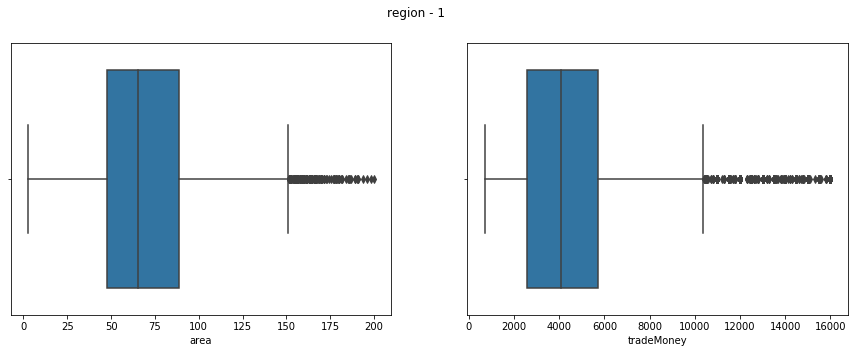

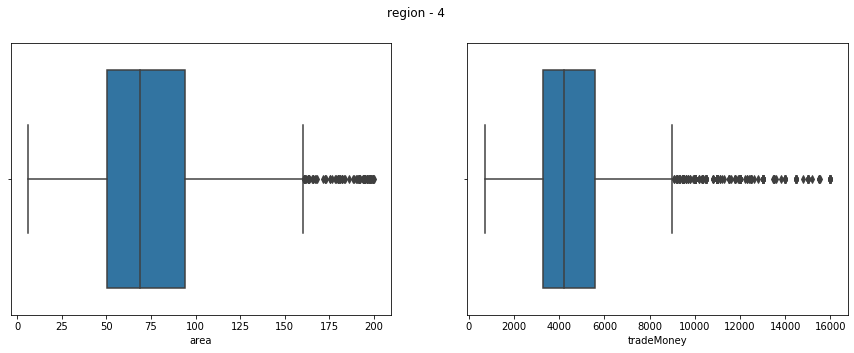

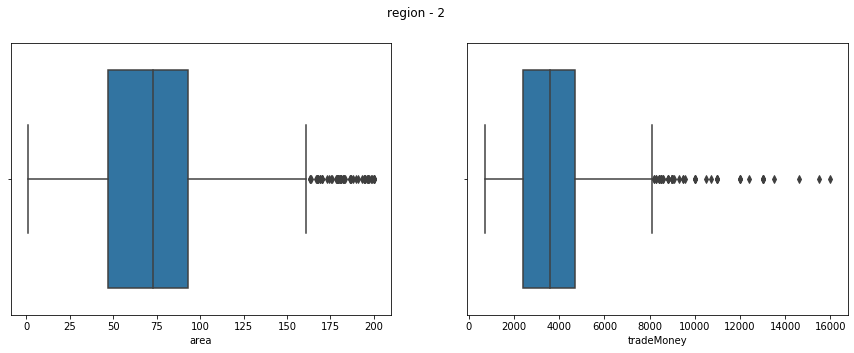

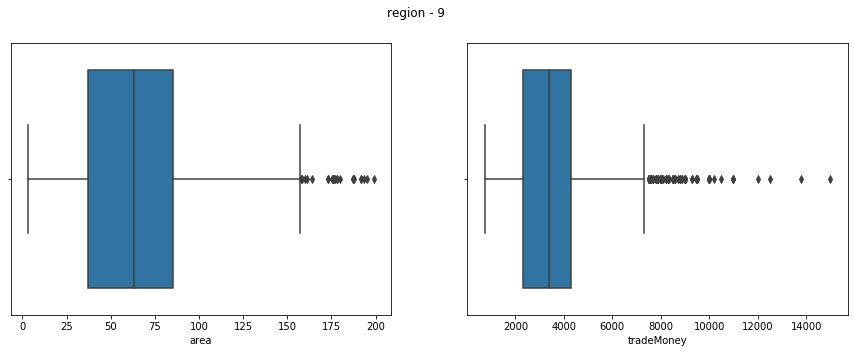

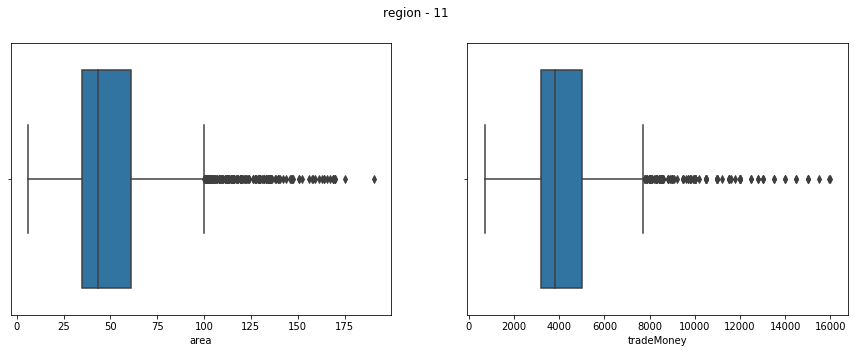

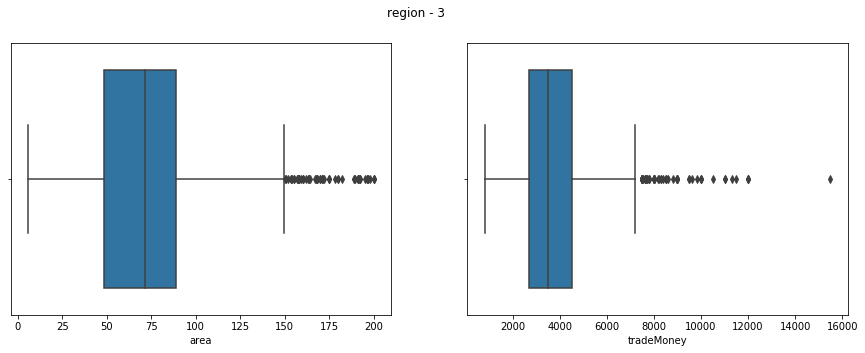

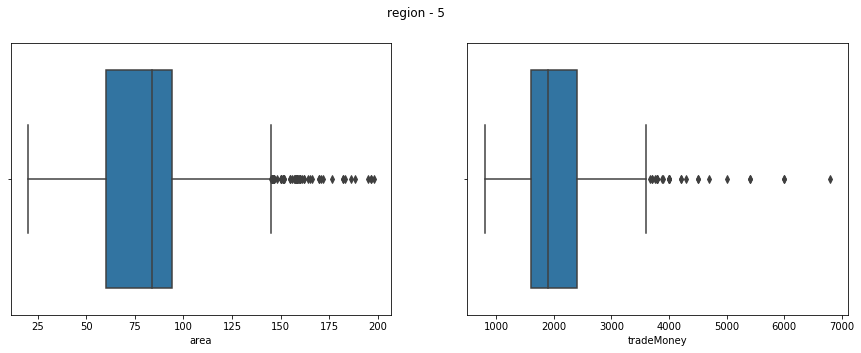

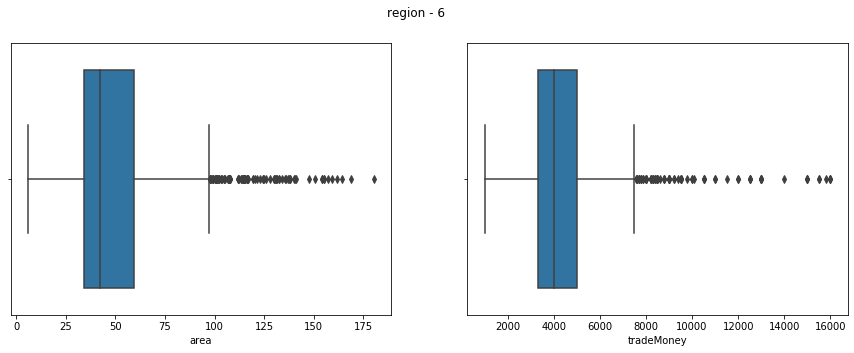

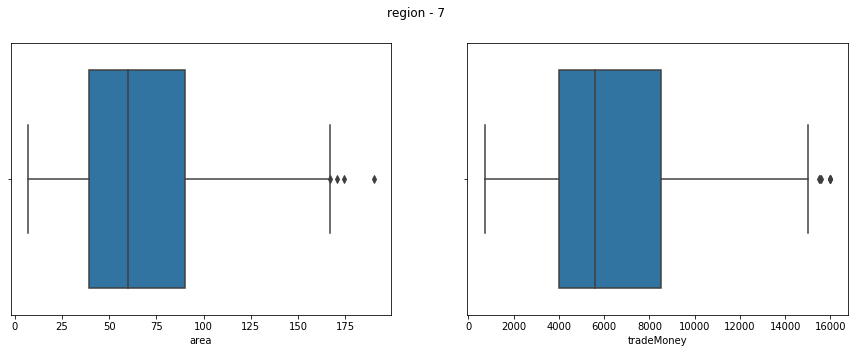

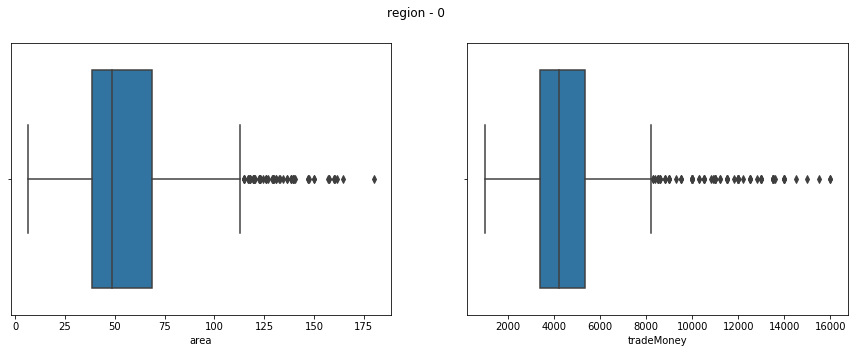

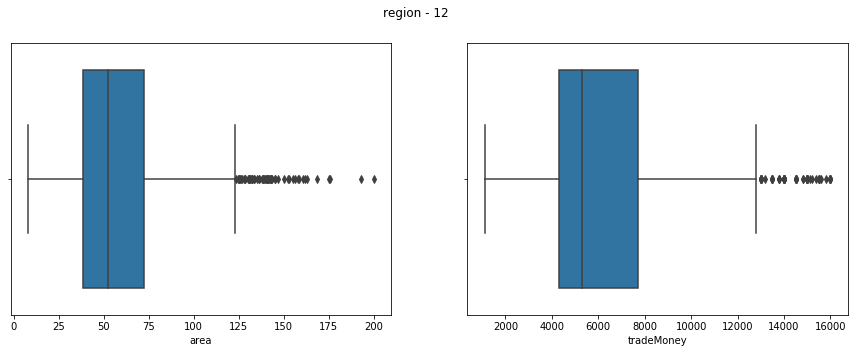

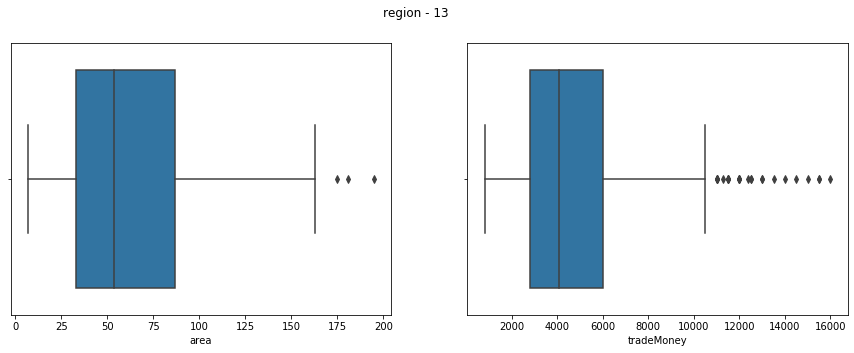

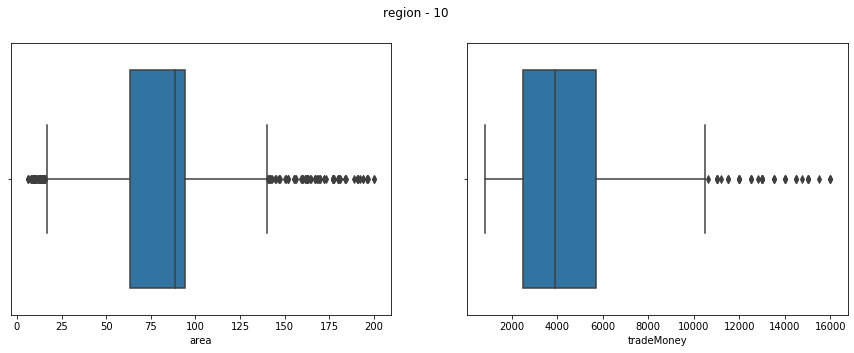

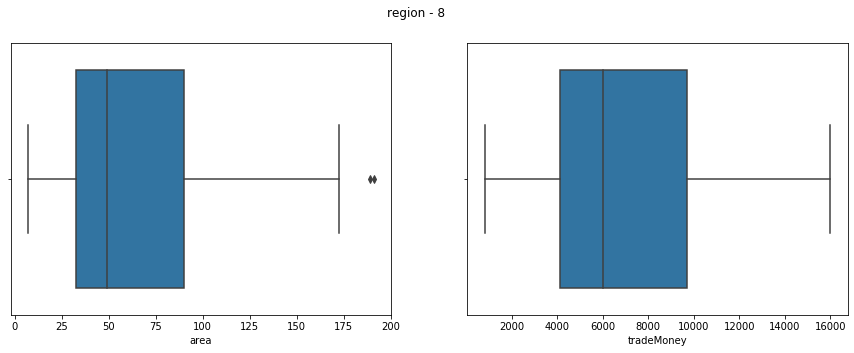

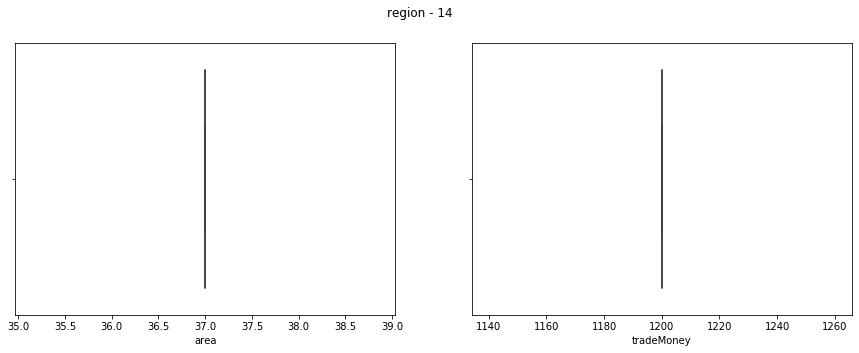

In [74]:
# 查看region不同地区下的 tradeMoney 和area
plt.figure(figsize = (15,5))
index = data_train['region'].value_counts().index
for i in index:
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    sns.boxplot(data_train[data_train['region'] == i]['area'])
    plt.subplot(1,2,2)
    sns.boxplot(data_train[data_train['region'] == i]['tradeMoney'])
    plt.suptitle('region - {}'.format(i))
    plt.show()

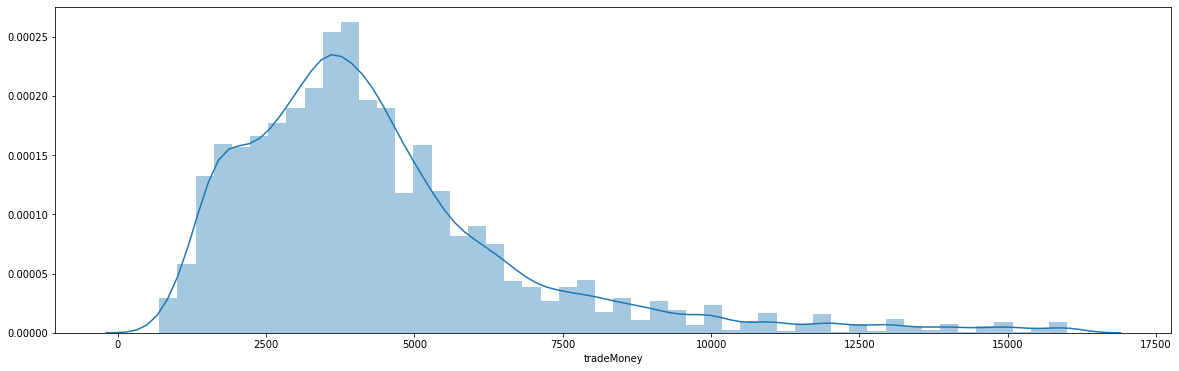

In [51]:
fig,axes = plt.subplots(1,1,figsize=(20,6))
sns.distplot(data_train['tradeMoney'])
plt.show()

In [14]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

data_train = cleanData(data_train)

In [15]:
data_train.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,12,1,16,6,0,50,0,63,...,28248,614,111546,1124,284,0,2000.0,Train,11,28
1,125.55,2,28,0,14,6,2,129,1,48,...,14823,148,157552,701,22,1,2000.0,Train,12,16
2,132.00,2,28,1,32,6,0,178,1,49,...,77645,520,131744,57,20,1,16000.0,Train,12,22
3,57.00,2,4,0,17,6,3,312,1,50,...,8750,1665,253337,888,279,9,1600.0,Train,12,21
4,129.00,2,29,1,2,6,1,1256,2,43,...,800,117,125309,2038,480,0,2900.0,Train,11,18


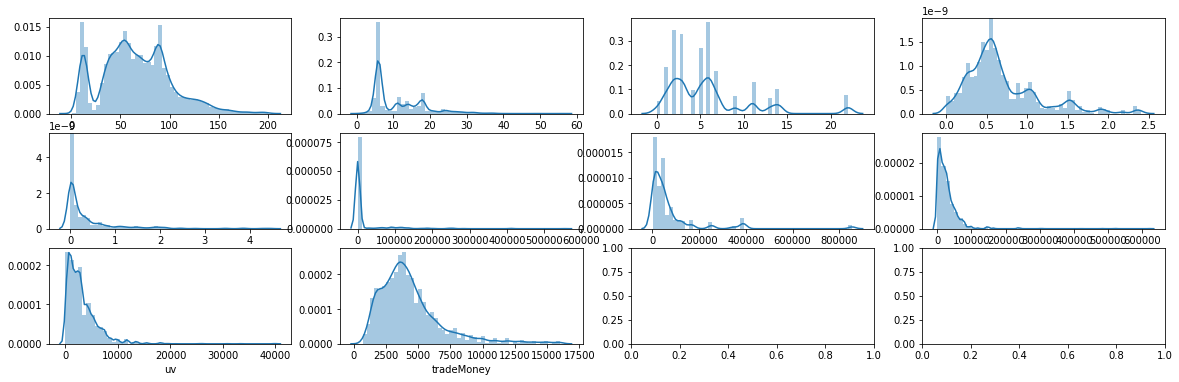

In [23]:
fig,axes = plt.subplots(3,4,figsize=(20,6))
sns.distplot(data_train['area'],ax=axes[0][0])
sns.distplot(data_train['totalFloor'],ax=axes[0][1])
sns.distplot(data_train['subwayStationNum'],ax=axes[0][2])
sns.distplot(data_train['totalTradeMoney'],ax=axes[0][3])
sns.distplot(data_train['totalNewTradeMoney'],ax=axes[1][0])
sns.distplot(data_train['supplyLandArea'],ax=axes[1][1])
sns.distplot(data_train['totalWorkers'],ax=axes[1][2])
sns.distplot(data_train['pv'],ax=axes[1][3])
sns.distplot(data_train['uv'],ax=axes[2][0])
sns.distplot(data_train['tradeMoney'],ax=axes[2][1])
plt.show()

Text(0, 0.5, 'tradeMoney')

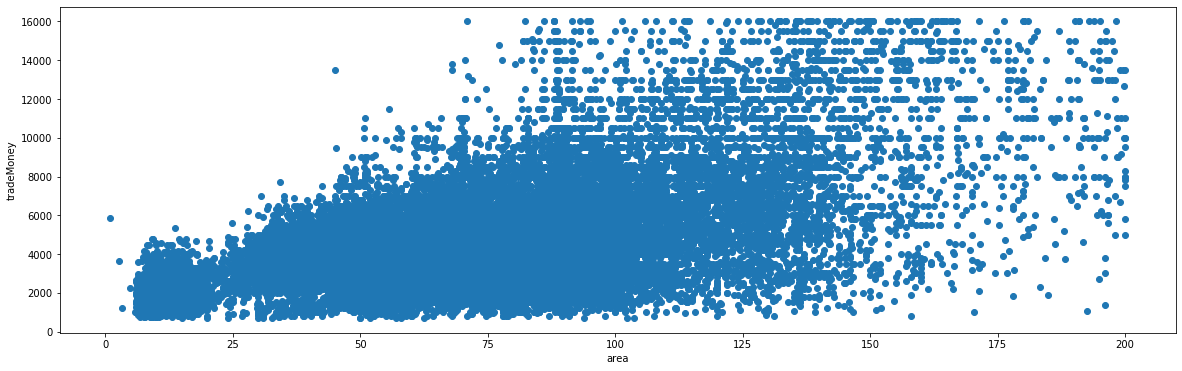

In [66]:
fig,axes = plt.subplots(1,1,figsize=(20,6))
plt.scatter(data_train['area'],data_train['tradeMoney'])
plt.xlabel('area')
plt.ylabel('tradeMoney')